# Variational Autoencoder (VAE)

Useful links: 
* Original paper http://arxiv.org/abs/1312.6114
* Helpful videos explaining the topic 
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

### Download data

In [1]:
# #!L
# from yfile import download_from_yadisk
# import os

# TARGET_DIR = '.'
# FILENAME = "celeba.zip"

# if not os.path.exists(os.path.join(TARGET_DIR, FILENAME)):
#     # we are going to download 1.4 gb file, downloading will take some time (8-10 minutes)
#     download_from_yadisk(
#         short_url='https://disk.yandex.ru/d/QErNx-MoC-2Y6Q',
#         filename=FILENAME,
#         target_dir=TARGET_DIR
#     )

#     # alternative way: 
#     #from gfile import download_list
#     #download_list(url=https://drive.google.com/file/d/1lwn2JMwWNGloGvyzKUOcewT8JqP1ICoW,
#     #               filename=FILENAME, target_dir=TARGET_DIR)

# filesize = os.path.getsize(os.path.join(TARGET_DIR, FILENAME))
# GB = 2**30
# assert filesize > 1 * GB, "{filesize} is too small, something wrong with downloading"

In [2]:
#!L:bash
# !unzip celeba.zip >> /dev/null

## Prepare the data

In [1]:
#!L
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.utils import make_grid

device = torch.device("cuda")

In [2]:
#!L
class CropCelebA64:
    
    def __call__(self, pic):
        new_pic = pic.crop((15, 40, 178 - 15, 218 - 30))
        return new_pic

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [3]:
#!L

# Note that for simplicity we reduce the number of channels to 1
# But if you want to be hardcore feel free to comment .Grayscale :)

train_dataset = torchvision.datasets.CelebA(
    root='celeba',
    split='train',
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        
        # torchvision.transforms.Grayscale()
    ]),
    #download=True,   # in case of problems with downloading from gdrive above
)

validation_dataset = torchvision.datasets.CelebA(
    root='celeba',
    split='valid',
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.ToTensor(),
        
        # torchvision.transforms.Grayscale()
    ]),
)

In [4]:
len(validation_dataset), len(train_dataset)

(19867, 162770)

In [5]:
# plt.imshow(train_dataset[0][0][0], cmap='gray')

In [6]:
#!L
# Save first 10k images for evaluation
num_images = 10000
real_images_tensor = torch.stack([train_dataset[i][0] for i in range(num_images)], dim=0)
real_images = real_images_tensor.data.numpy().transpose([0, 2, 3, 1])
np.savez("real.npz", Pictures=real_images.reshape(num_images, 64 * 64 * 3))

In [7]:
#!L
BATCH_SIZE = 128

# you may find useful parameters `num_workers` and `pin_memory`
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)

# Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:

In [8]:
train_dataset[1][0].shape

torch.Size([3, 64, 64])

In [9]:
#!L
dimZ = 256  # Considering face reconstruction task, which size of representation seems reasonable?

# Define the decoder and encoder as networks with one hidden fc-layer
# (that means you will have 2 fc layers in each net)
# Use ReLU for hidden layers' activations
# GlorotUniform initialization for W
# Zero initialization for biases
# It's also convenient to put sigmoid activation on output layer to get nice normalized pics
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encode = torch.nn.Sequential(
            nn.Linear(3*64*64, dimZ),
            nn.BatchNorm1d(dimZ),
            nn.LeakyReLU(),
            nn.Linear(dimZ, dimZ),
            nn.BatchNorm1d(dimZ),
        )

        self.decode = torch.nn.Sequential(
            nn.Linear(dimZ, dimZ),
            nn.BatchNorm1d(dimZ),
            nn.LeakyReLU(),
            nn.Linear(dimZ, 3*64*64),
            nn.Sigmoid()
        )

        # self.encode = torch.nn.Sequential(
        #     nn.Conv2d(3, 16, kernel_size=3),
        #     nn.LeakyReLU(),
        #     nn.MaxPool2d(2),#16*26*26
        #     nn.BatchNorm2d(16),
        #     nn.Conv2d(16, 32, kernel_size=3),
        #     nn.LeakyReLU(),
        #     nn.MaxPool2d(2), #32*12*12
        #     nn.BatchNorm2d(32),
        #     nn.Conv2d(32, 64, kernel_size=3),
        #     nn.LeakyReLU(),
        #     nn.MaxPool2d(2), # 64*5*5
        #     nn.BatchNorm2d(64),
        #     nn.Conv2d(64, 128, kernel_size=3),
        #     nn.LeakyReLU(), # 128*4*4
        #     nn.Flatten(),
        #     nn.Linear(128*4*4, dimZ)
        # )

        # self.decode = torch.nn.Sequential(
        #     nn.Linear(dimZ, 128*4*4),
        #     nn.LeakyReLU(),
        #     View((-1, 128, 4, 4)),
        #     nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
        #     nn.BatchNorm2d(64),
        #     nn.LeakyReLU(),
        #     nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
        #     nn.BatchNorm2d(32),
        #     nn.LeakyReLU(),
        #     nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
        #     nn.BatchNorm2d(16),
        #     nn.LeakyReLU(),
        #     nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2),
        #     nn.Sigmoid()
        # )

    def forward(self, x):
        # We can ask to code things here
        
        # print(x.shape)
        latent_code = self.encode(x)
        # print(latent_code.shape)
        reconstruction = self.decode(latent_code)
        # reconstruction = reconstruction.view(x.shape[0], 3, 64, 64)
        # print(reconstruction.shape)
        # print(x.shape, reconstruction.shape)
        return reconstruction, latent_code

    def sample(self, n_samples):
        """ This is the method you need to code in your Homework"""
        pass

In [10]:
#!L
# Create MSE loss function
criterion = torch.nn.MSELoss()

autoencoder = Autoencoder().to(device)


optimizer = torch.optim.SGD(autoencoder.parameters(), lr=4., momentum=0.9, nesterov=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, verbose=True, patience=5)

In [11]:
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import pandas as pd
def compute_loss(X_batch, y_batch):
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    
    probs, _ = autoencoder(X_batch)
    # print(X_batch.shape, y_batch.shape, probs.shape)
    return F.mse_loss(probs, y_batch)

In [264]:
# Train your autoencoder
import time
from IPython import display
def train_model(model, opt, train_loader, val_loader, train_loss, val_loss, num_epochs):
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        start_time = time.time()
        model.train(True) # enable dropout / batch_norm training behavior
        loss_batch = []
        for X_batch, _ in train_loader:
            # train on batch
            X_batch = X_batch.view(X_batch.shape[0], -1)
            loss = compute_loss(X_batch, X_batch)
            loss.backward()
            opt.step()
            opt.zero_grad()
            loss_batch.append(loss.data.cpu().numpy())
        train_loss.append(np.mean(loss_batch))

        model.train(False)

        loss_batch = []
        for X_batch, _ in val_loader:
            X_batch = X_batch.view(X_batch.shape[0], -1)
            probs, _ = model(X_batch.to(device))
            x_pred = probs.data.cpu().numpy()
            X_batch = X_batch.cpu().numpy()
            X_batch = X_batch.reshape(X_batch.shape[0], -1)
            x_pred = x_pred.reshape(x_pred.shape[0], -1)
            loss_batch.append(mean_squared_error(X_batch, x_pred))
        val_loss.append(np.mean(loss_batch))


        # Visualize
        display.clear_output(wait=True)
        plt.figure(figsize=(8, 6))
        plt.title("Validation loss")
        plt.xlabel("#Epoch")
        plt.ylabel("loss")
        plt.plot(val_loss, 'b',label='val loss')
        plt.plot(pd.Series(val_loss).ewm(span=10).mean(),'r',label='ewm val loss')
        plt.legend(loc='best')
        plt.grid()
        plt.show()

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss[-1]))

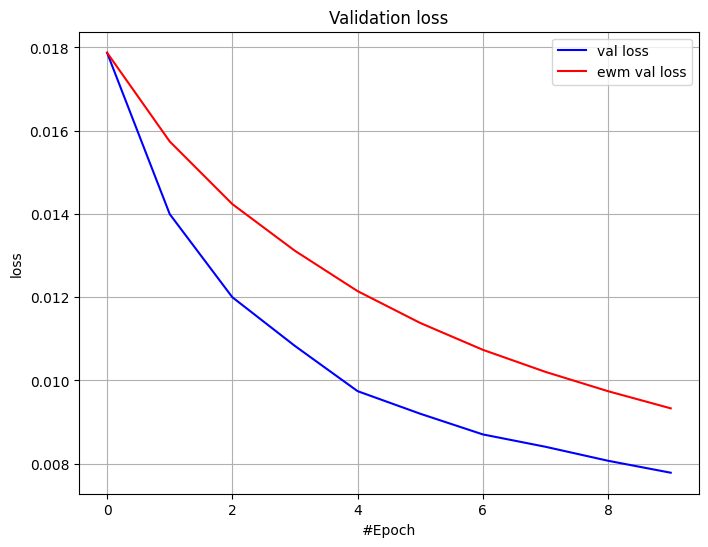

Epoch 10 of 10 took 23.998s
  training loss (in-iteration): 	0.008424


In [265]:
val_loss, train_loss = [], []
train_model(autoencoder, optimizer, train_loader, val_loader, train_loss, val_loss, 10)

torch.Size([128, 12288])


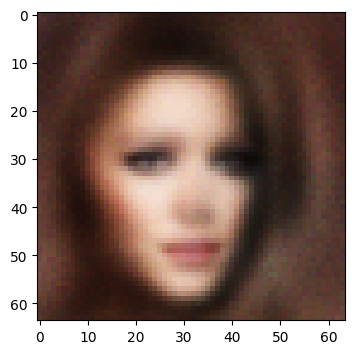

torch.Size([128, 12288])


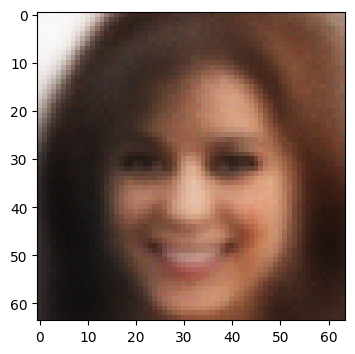

torch.Size([128, 12288])


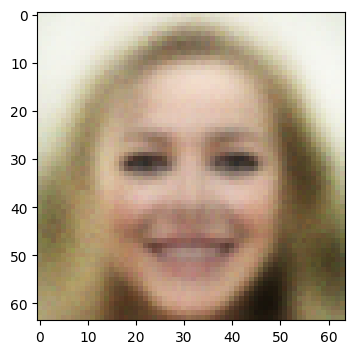

torch.Size([128, 12288])


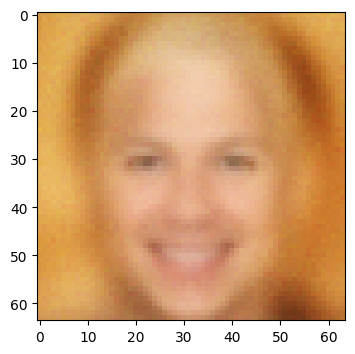

torch.Size([128, 12288])


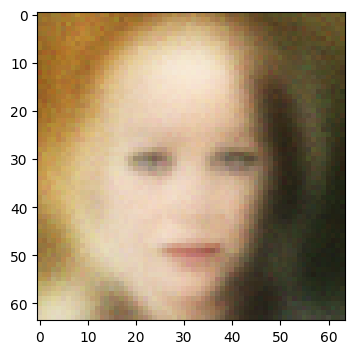

torch.Size([128, 12288])


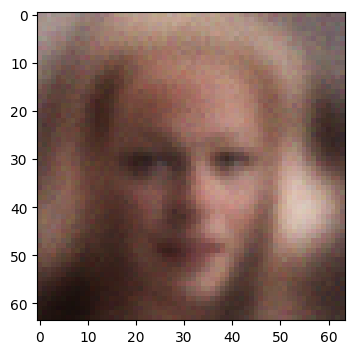

torch.Size([128, 12288])


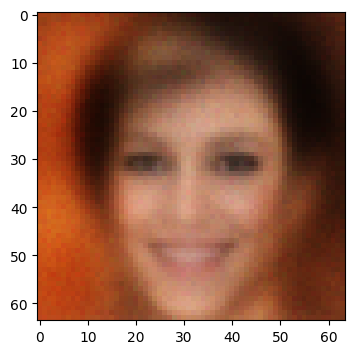

torch.Size([128, 12288])


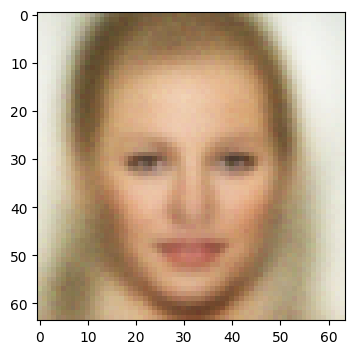

torch.Size([128, 12288])


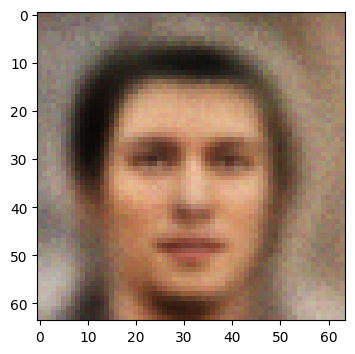

torch.Size([128, 12288])


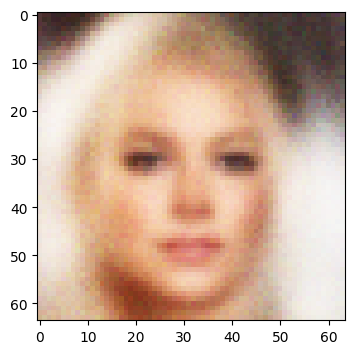

In [273]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

# Examine the reconstructions
autoencoder.train(False)
with torch.no_grad():
    for j, (X_batch, _) in enumerate(val_loader, 0):
        X_batch = X_batch.view(X_batch.shape[0], -1)
        inp = X_batch.to(device)
        print(inp.shape)
        pred, _ = autoencoder(inp)
        pred = pred.view(pred.shape[0], 3, 64, 64)
        # print(inp.shape)
        plt.figure(figsize=(4, 4))
        plt.imshow(pred[2].permute(1, 2, 0).cpu().numpy())
        plt.show()
        # plot_gallery([pred[0].cpu().numpy(), pred[0].data.cpu().numpy()], 64, 64, n_row=1, n_col=2)
        if (j >= 9):
            break

Reconstruction is not bad, right? 

# Sampling

Let's now sample several latent vectors and perform inference from $z$, reconstruct an image given some random $z$ representations.

In [274]:
def display_images(tensor):
    # Assuming the tensor is of shape (16, 3, 64, 64)
    if tensor.shape[0] != 16 or tensor.shape[1] != 3:
        raise ValueError("Tensor should be of shape (16, 3, 64, 64)")

    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for i in range(16):
        ax = axes[i // 4, i % 4]
        img = tensor[i].permute(1, 2, 0)  # Change shape from (3, 64, 64) to (64, 64, 3)
        img = img / 2 + 0.5  # unnormalize if the images were normalized
        ax.imshow(img)
        ax.axis('off')
    plt.show()

In [285]:
def display_single_image(tensor):
    # Assuming the tensor is of shape (3, 64, 64)
    if tensor.shape != (3, 64, 64):
        raise ValueError("Tensor should be of shape (3, 64, 64)")

    img = tensor.permute(1, 2, 0)  # Change shape from (3, 64, 64) to (64, 64, 3)
    img = img / 2 + 0.5  # unnormalize if the images were normalized
    plt.imshow(img)
    plt.axis('off')
    plt.show()

torch.Size([16, 256])
torch.Size([16, 3, 64, 64])


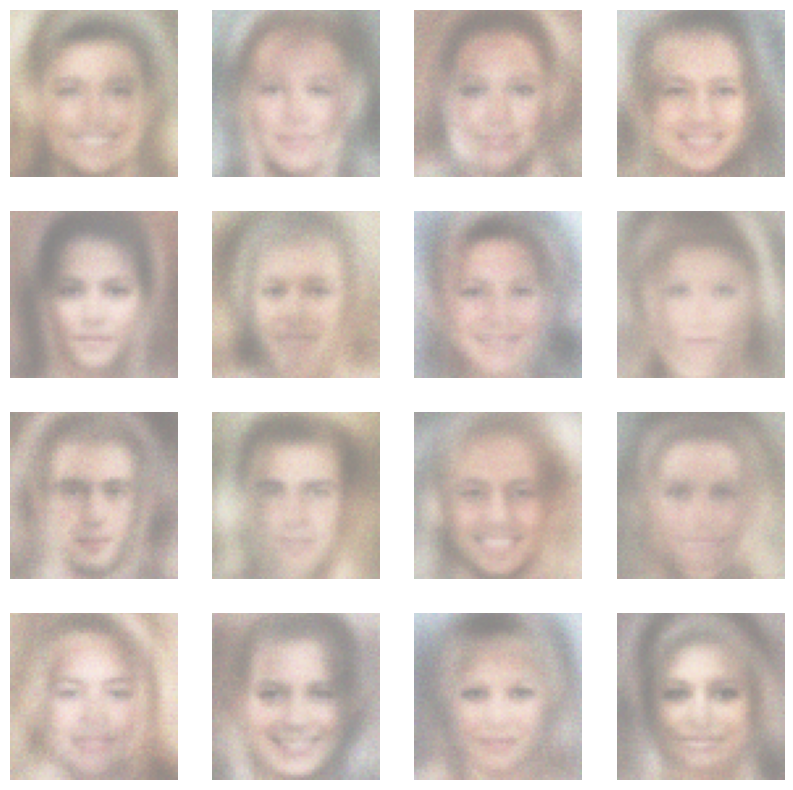

In [289]:
#!L
z = torch.randn(16, dimZ)
print(z.shape)
reconstruction = autoencoder.decode(z.to(device)).clamp(0, 1).detach().cpu()
reconstruction = reconstruction.view(reconstruction.shape[0], 3, 64, 64)
print(reconstruction.shape)

# plt.imshow(make_grid(reconstruction.cpu(), nrow=5).permute(1, 2, 0))
display_images(reconstruction)

So, if we sample $z$ from normal, whould we eventually generate all possible faces? What do you think?

# Variational Autoencoder

Bayesian approach in deep learning considers everything in terms of distributions. Now our encoder generates not just a vector $z$ but posterior ditribution $q(z|x)$. In our case distribution $q$ is Gaussian distibution $N(\mu, \sigma)$ with parameters $\mu$, $\sigma$. Technically, the first difference is that you need to split bottleneck layer in two. One dense layer will generate vector $\mu$, and another will generate vector $\sigma$. Reparametrization trick should be implemented using the **gaussian_sampler** layer, that generates random vetor $\epsilon$ and returns $\mu+\sigma\epsilon \sim N(\mu, \sigma)$ .

Since our decoder is also a function that generates distribution, we need to do the same splitting for output layer. When testing the model we will look only on mean values, so one of the output will be actual autoencoder output.

In this homework we only ask for implementation of the simplest version of VAE - one $z$ sample per input. You can consider to sample several outputs from one input and average them.

In [66]:
dimZ = 100
#!L
# to compare with conventional AE, keep these hyperparameters
# or change them for the values that you used before


# define the network
# you can start from https://github.com/pytorch/examples/blob/master/vae/main.py
# or Theano-based examples here https://github.com/Lasagne/Recipes/blob/master/examples/variational_autoencoder/variational_autoencoder.py
# and here https://github.com/y0ast/Variational-Autoencoder/blob/master/VAE.py
# but remember that this is not your ground truth since the data is not MNIST


In [112]:
class Encoder(nn.Module):
    def __init__(self, dimZ):
        super(Encoder, self).__init__()
        # Convolutional layers
        # self.conv_layers = nn.Sequential(
        #     nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # Output size: [32, 32, 32]
        #     nn.LeakyReLU(),
        #     nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output size: [64, 16, 16]
        #     nn.LeakyReLU(),
        #     nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # Output size: [128, 8, 8]
        #     nn.LeakyReLU(),
        #     nn.Flatten(),  # Flatten for the linear layers
        # )

        self.conv_layers = torch.nn.Sequential(
            nn.Linear(3*64*64, 3*32*32),
            nn.BatchNorm1d(3*32*32),
            nn.LeakyReLU(),
            nn.Linear(3*32*32, 3*16*16),
            nn.BatchNorm1d(3*16*16),
        )

        # Linear layers for mean and log-variance
        self.fc_mu = nn.Linear(3*16*16, dimZ)
        self.fc_logvar = nn.Linear(3*16*16, dimZ)

    def forward(self, x):
        x = self.conv_layers(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.up_layers = torch.nn.Sequential(
            nn.Linear(dimZ, dimZ),
            nn.BatchNorm1d(dimZ),
            nn.LeakyReLU()
        )
        self.mu_layer = nn.Sequential(nn.Linear(dimZ, 3*64*64), nn.Sigmoid())
        self.logsigma_layer = nn.Sequential(nn.Linear(dimZ, 3*64*64))

    def forward(self, x):
        layers = self.up_layers(x)
        reconstruction_mu = self.mu_layer(layers)
        reconstruction_logsigma = self.logsigma_layer(layers)
        return reconstruction_mu, reconstruction_logsigma

class VAE(nn.Module):

    def __init__(self):
        super(VAE, self).__init__()
        self.encode = Encoder(dimZ)
        self.decode = Decoder()

    def gaussian_sampler(self, mu, logsigma):
        noise = torch.randn_like(mu)
        return noise * logsigma.exp() + mu

    def forward(self, x):
        latent_mu, latent_logsigma = self.encode(x)
        z = self.gaussian_sampler(latent_mu, latent_logsigma)
        reconstruction_mu, reconstruction_logsigma = self.decode(z)
        return reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma

And the last, but not least! Place in the code where the most of the formulaes goes to - optimization objective. The objective for VAE has it's own name - variational lowerbound. And as for any lowerbound our intention is to maximize it. Here it is (for one sample $z$ per input $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z) \to max$$

Your next task is to implement two functions that compute KL-divergence and the second term - log-likelihood of an output. Here is some necessary math for your convenience:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_i-x)^2}{2\sigma_i^2}} \Big)=...$$

Don't forget in the code that you are using $\log\sigma$ as variable. Explain, why not $\sigma$?

In [132]:
# #!L
# def KL_divergence(mu, logsigma):
#     return -0.5 * torch.sum(1 + logsigma - mu.pow(2) - (logsigma.exp() + 1e-8))

# def log_likelihood(x, mu, logsigma):
#     # Adding epsilon for numerical stability
#     epsilon = 1e-8
#     sigma = logsigma.exp() + epsilon
#     return torch.sum(1 / (sigma *  ( (2 * torch.pi)**0.5 ) ) * torch.exp(-((mu - x).pow(2) / (2 * sigma))))

# def loss_vae(x, mu_gen, logsigma_gen, mu_z, logsigma_z):
#     # return  - (- KL_divergence(mu_z, logsigma_z) + log_likelihood(x, mu_gen, logsigma_gen))
#     return   (  log_likelihood(x, mu_gen, logsigma_gen) - KL_divergence(mu_z, logsigma_z))

def KL_divergence(mu, logsigma):
    return - 0.5 * (1 + 2 * logsigma  - mu.pow(2) - logsigma.exp().pow(2)).sum(dim=-1)

def log_likelihood(x, mu, logsigma):
    return - (logsigma  +\
              (mu - x).pow(2) / logsigma.exp().pow(2) * 0.5).sum(dim=-1)

def loss_vae(x, mu_decoder, logstd_decoder, mu_encoder, logstd_encoder):
    KL_value = KL_divergence(mu_encoder, logstd_encoder)
    log_value = log_likelihood(x, mu_decoder, logstd_decoder)
    return - (- 0.5 * KL_value + log_value).mean()

In [133]:
class VAE(nn.Module):
    def __init__(self, input_size=3*64*64, hidden_size=400):
        super(VAE, self).__init__()

        self.fc_encode = nn.Linear(input_size, hidden_size)
        self.mu_encode = nn.Linear(hidden_size, dimZ)
        self.logstd_encode = nn.Linear(hidden_size, dimZ)


        self.fc_decode = nn.Linear(dimZ, hidden_size)
        self.mu_decode = nn.Linear(hidden_size, input_size)
        self.logstd_decode = nn.Linear(hidden_size, input_size)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.bn_encode = nn.BatchNorm1d(hidden_size)
        self.bn_decode = nn.BatchNorm1d(hidden_size)

        self.bn_mu_encode = nn.BatchNorm1d(dimZ)

    def encode(self, x):
        hidden = self.relu(self.bn_encode(self.fc_encode(x)))
        return self.bn_mu_encode(self.mu_encode(hidden)), self.logstd_encode(hidden)

    def decode(self, z):
        hidden = self.relu(self.bn_decode(self.fc_decode(z)))
        return self.sigmoid(self.mu_decode(hidden)),\
               self.logstd_decode(hidden)

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = logsigma.exp()
            eps = torch.zeros_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        mu_encoder, logstd_encoder = self.encode(x)
        z = self.gaussian_sampler(mu_encoder, logstd_encoder)
        mu_decoder, logstd_decoder = self.decode(z)

        return mu_decoder, logstd_decoder, mu_encoder, logstd_encoder

    def sample(self, n_samples):
        """ This is the method you need to code in your Homework"""
        pass

And train the model:

In [134]:
#!L
# train your variational autoencoder
# visualize progress in reconstruction and loss decay

# Train your autoencoder
import time
from IPython import display
def train_model(model, opt, train_loader, val_loader, train_loss, val_loss, num_epochs):
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        start_time = time.time()
        model.train(True) # enable dropout / batch_norm training behavior
        loss_batch = []
        for X_batch, _ in train_loader:
            # train on batch
            X_batch = X_batch.view(X_batch.shape[0], -1).to(device)
            reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma = model(X_batch)
            loss = loss_vae(X_batch, reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma)
            loss.backward()
            opt.step()
            opt.zero_grad()
            loss_batch.append(loss.data.cpu().numpy())
        train_loss.append(np.mean(loss_batch))

        model.train(False)

        loss_batch = []
        for X_batch, _ in val_loader:
            X_batch = X_batch.view(X_batch.shape[0], -1).to(device)
            reconstruction_mu, _, _, _ = model(X_batch)
            x_pred = reconstruction_mu.data.cpu().numpy()
            X_batch = X_batch.cpu().numpy()
            X_batch = X_batch.reshape(X_batch.shape[0], -1)
            x_pred = x_pred.reshape(x_pred.shape[0], -1)
            loss_batch.append(mean_squared_error(X_batch, x_pred))
        val_loss.append(np.mean(loss_batch))


        # Visualize
        display.clear_output(wait=True)
        plt.figure(figsize=(8, 6))
        plt.title("Validation loss")
        plt.xlabel("#Epoch")
        plt.ylabel("loss")
        plt.plot(val_loss, 'b',label='val loss')
        plt.plot(pd.Series(val_loss).ewm(span=10).mean(),'r',label='ewm val loss')
        plt.legend(loc='best')
        plt.grid()
        plt.show()

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss[-1]))

In [135]:
autoencoder = VAE().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.0003)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, verbose=True, patience=5)

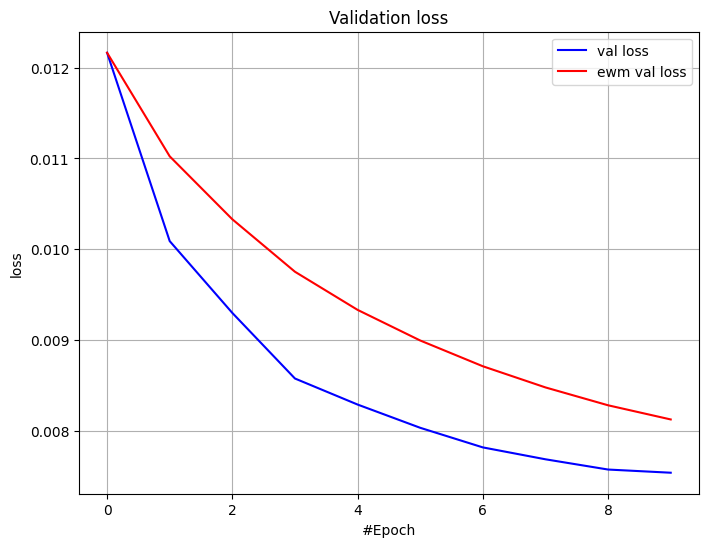

Epoch 10 of 10 took 23.109s
  training loss (in-iteration): 	-25656.675781


In [136]:
val_loss, train_loss = [], []
train_model(autoencoder, optimizer, train_loader, val_loader, train_loss, val_loss, 10)

torch.Size([128, 12288])


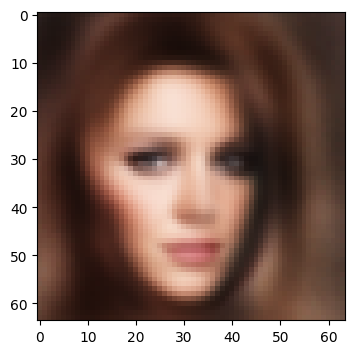

torch.Size([128, 12288])


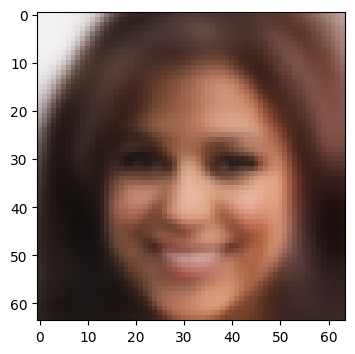

torch.Size([128, 12288])


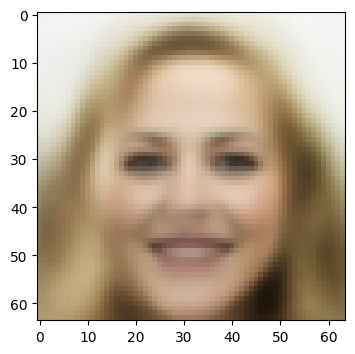

torch.Size([128, 12288])


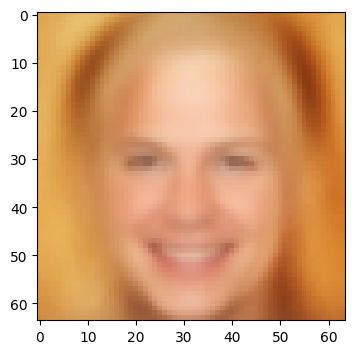

torch.Size([128, 12288])


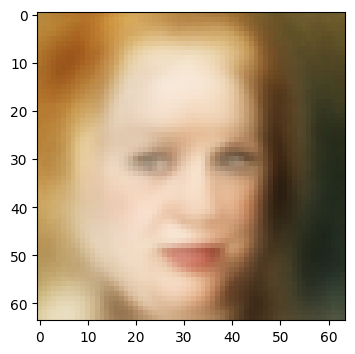

torch.Size([128, 12288])


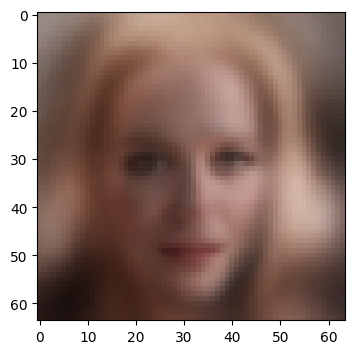

torch.Size([128, 12288])


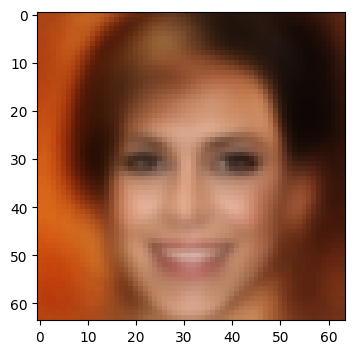

torch.Size([128, 12288])


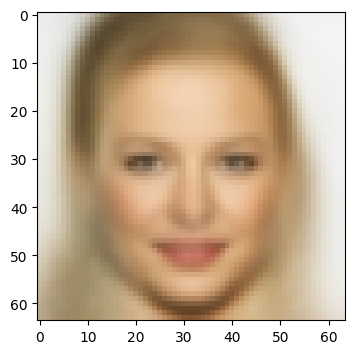

torch.Size([128, 12288])


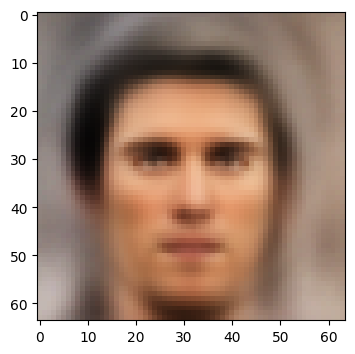

torch.Size([128, 12288])


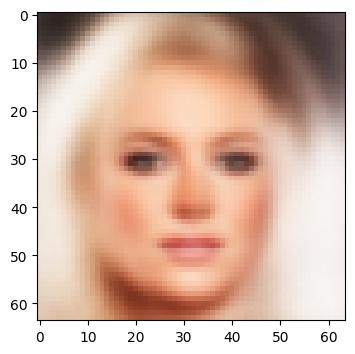

In [137]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

# Examine the reconstructions
autoencoder.train(False)
with torch.no_grad():
    for j, (X_batch, _) in enumerate(val_loader, 0):
        X_batch = X_batch.view(X_batch.shape[0], -1)
        inp = X_batch.to(device)
        print(inp.shape)
        pred, _, _, _ = autoencoder(inp)
        pred = pred.view(pred.shape[0], 3, 64, 64)
        # print(inp.shape)
        plt.figure(figsize=(4, 4))
        plt.imshow(pred[2].permute(1, 2, 0).cpu().numpy())
        plt.show()
        # plot_gallery([pred[0].cpu().numpy(), pred[0].data.cpu().numpy()], 64, 64, n_row=1, n_col=2)
        if (j >= 9):
            break

And finally sample from VAE.

In [153]:
#!L
# TODO
# Sample some images from the learned distribution
# 1) Sample z ~ N(0,1)
# 2) Sample from N(decoder_mu(z), decoder_sigma(z))
with torch.no_grad():
    z = torch.randn(25, dimZ).to(device)
    mu, logstd = autoencoder.decode(z)
    # std = logstd.exp()
    # eps = torch.randn_like(std)
    mu_decoder = mu #eps.mul(std).add_(mu)

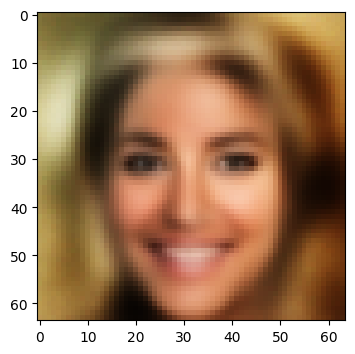

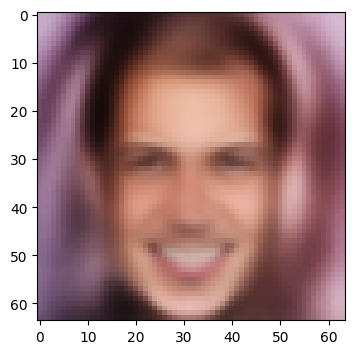

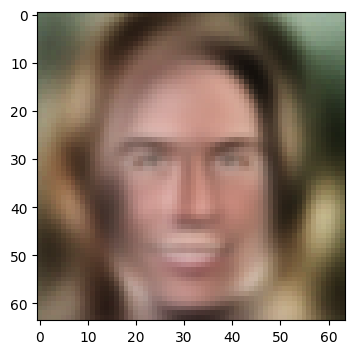

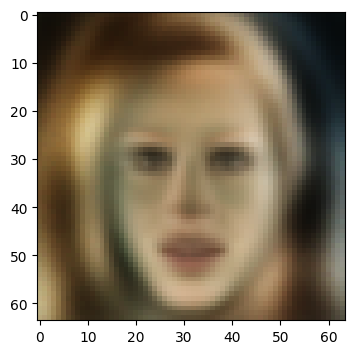

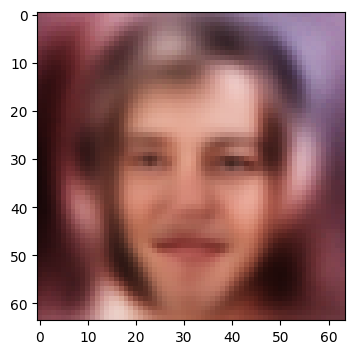

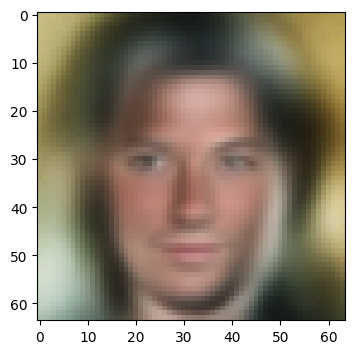

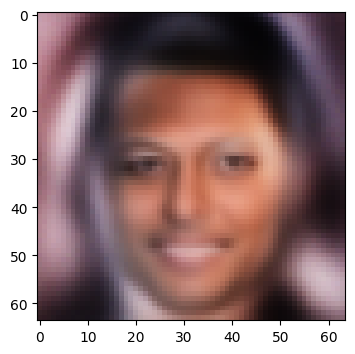

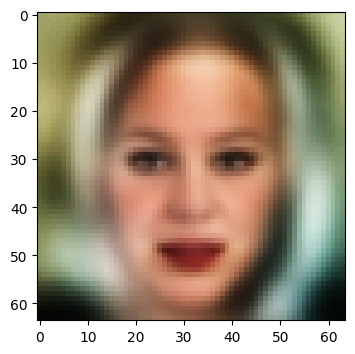

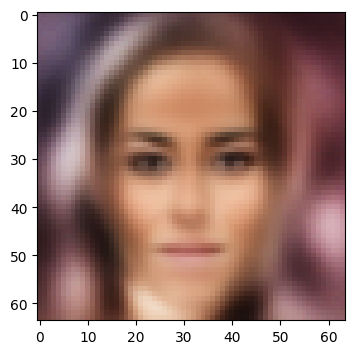

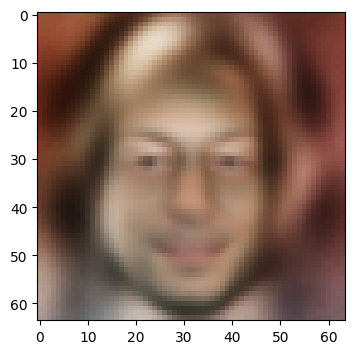

In [154]:
for j in range(mu_decoder.shape[0]):
    pred = mu_decoder[j]
    pred = pred.view(3, 64, 64)
    # print(inp.shape)
    plt.figure(figsize=(4, 4))
    plt.imshow(pred.permute(1, 2, 0).cpu().numpy())
    plt.show()
    # plot_gallery([pred[0].cpu().numpy(), pred[0].data.cpu().numpy()], 64, 64, n_row=1, n_col=2)
    if (j >= 9):
        break

Even if in practice you do not see the much difference between AE and VAE, or VAE is even worse, the little bayesian inside you should be jumping for joy right now. 

In VAE you can truly sample from image distribution $p(x)$, while in AE there is no easy and correct way to do it. 

# Congrats! and Bonus

If you managed to tune your autoencoders to converge and learn something about the world, now it's time to make fun out of it. As you may have noticed, there are face attributes in dataset. We're interesting in "Smiling" column (index 31 of the attribute vector), but feel free to try others as well! Here is the first task:

1) Extract the "Smilling" attribute and create a two sets of images: 10 smiling faces and 10 non-smiling ones.

2) Compute latent representations for each image in "smiling" set and average those latent vectors. Do the same for "non-smiling" set. You have found **"vector representation"** of the "smile" and "no smile" attribute.

3) Compute the difference: "smile" vector minus "non-smile" vector.

3) Now check if **"feature arithmetics"** works. Sample a face without smile, encode it and add the diff from p. 3. Check if it works with both AE and VAE. 

<img src="linear.png" alt="linear">